#Analysis of classifiers

In this part of the code a connection is made between github and this file.
All the documents from github are imported, inluding our data.
The files that are not needed for our assignment were deleted from github.

In [1]:
!pip install -q --upgrade git+https://github.com/NFAFrijns/TM10007_G1_lipo.git

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 18.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 18.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 13.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 1.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 2.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 8.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 9.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 MB 8.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.0/196.0 MB 6.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 166.0/166.0 MB 7.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.1/99.1 kB 12.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 46

Shape of X: (115, 5)


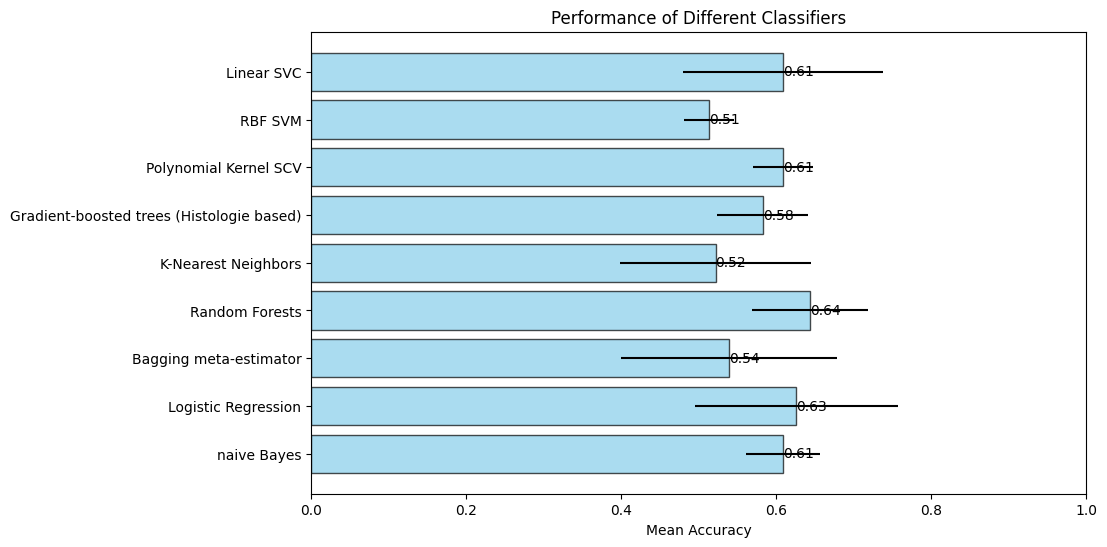

In [2]:
import pandas as pd
from worclipo.load_data import load_data
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.model_selection import cross_val_score
from sklearn import svm
from sklearn.ensemble import HistGradientBoostingClassifier, ExtraTreesClassifier, BaggingClassifier, VotingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

feature_data = load_data()
X = feature_data.iloc[:, 2:7]
y = feature_data['label']
#X = X.clip(lower=0) # Ensure non-negative values
#X = SelectKBest(score_func=chi2, k=2).fit_transform(X, y)
print("Shape of X:", X.shape)

classifiers = [
    (svm.SVC(kernel='linear', C=1.0, random_state=42), "Linear SVC"),
    (svm.SVC(kernel="rbf", gamma=0.7, C=1.0), "RBF SVM"),
    (svm.SVC(kernel="poly", degree=2, gamma="auto", C=1.0), "Polynomial Kernel SCV"),
    (HistGradientBoostingClassifier(max_iter=100), "Gradient-boosted trees (Histologie based)"),
    (KNeighborsClassifier(n_neighbors=5), "K-Nearest Neighbors"),
    (ExtraTreesClassifier(n_estimators=10, max_depth=None, min_samples_split=2, random_state=0), "Random Forests"),
    (BaggingClassifier(KNeighborsClassifier(), max_samples=0.5, max_features=0.5), "Bagging meta-estimator"),
    (LogisticRegression(random_state=1), "Logistic Regression"),
    (GaussianNB(), "naive Bayes")
]

results = {}
for clf, label in classifiers:
    scores = cross_val_score(clf, X, y, cv=5)
    mean_accuracy = scores.mean()
    std_dev = scores.std()
    results[label] = (mean_accuracy, std_dev)

# Plot results
labels = list(results.keys())
mean_accuracies = [result[0] for result in results.values()]
std_devs = [result[1] for result in results.values()]

plt.figure(figsize=(10, 6))
bars = plt.barh(labels, mean_accuracies, xerr=std_devs, color='skyblue', edgecolor='black', alpha=0.7)

for bar, accuracy in zip(bars, mean_accuracies):
    plt.text(bar.get_width(), bar.get_y() + bar.get_height()/2, f'{accuracy:.2f}', va='center')

plt.xlabel('Mean Accuracy')
plt.title('Performance of Different Classifiers')
plt.xlim(0, 1)
plt.gca().invert_yaxis()
plt.show()
